# Dirty Café Sales – End‑to‑End Cleaning & Mixed‑Type Clustering
*Generated 2025‑06-22 04:53*

Este notebook executa:
1. Carregamento e inspeção do dataset sujo.
2. Limpeza e imputação de valores faltantes/errôneos.
3. Engenharia de atributos úteis (datas, ticket médio, indicadores de sujeira).
4. Clusterização **K‑Prototypes** para dados mistos (numéricos + categóricos).
5. Validação (Silhouette) e análise de perfis dos clusters.

> **Dependências**  
> `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit‑learn`, `kmodes`  
> Instale faltantes com `pip install kmodes seaborn`.

Mounted at /content/drive


In [ ]:
!pip install kmodes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
import warnings, os, re, datetime as dt
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [ ]:
# Ajuste o caminho se necessário
DATA_PATH = 'dirty_cafe_sales.csv'
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (10000, 8)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [ ]:
invalid_tokens = ['ERROR', 'UNKNOWN', 'None', 'none', 'NONE', ' ', '', np.nan]
# Troca tokens inválidos por NaN
df.replace(invalid_tokens, np.nan, inplace=True)

# Info inicial
display(df.isna().mean().to_frame('missing_rate').style.format({'missing_rate': '{:.1%}'}))

,missing_rate
Transaction ID,0.0%
Item,9.7%
Quantity,4.8%
Price Per Unit,5.3%
Total Spent,5.0%
Payment Method,31.8%
Location,39.6%
Transaction Date,4.6%


In [ ]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Recalcula Total Spent sempre que possível
mask = df['Total Spent'].isna() & df['Quantity'].notna() & df['Price Per Unit'].notna()
df.loc[mask, 'Total Spent'] = df.loc[mask, 'Quantity'] * df.loc[mask, 'Price Per Unit']

# Corrige incoerências
diff = df['Quantity'] * df['Price Per Unit'] - df['Total Spent']
inconsistent = diff.abs() > 1e-2
df.loc[inconsistent, 'Total Spent'] = df.loc[inconsistent, 'Quantity'] * df.loc[inconsistent, 'Price Per Unit']

df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,9521.0,3.028463,1.419007,1.0,2.0,3.0,4.0,5.0
Price Per Unit,9467.0,2.949984,1.278450,1.0,2.0,3.0,4.0,5.0
Total Spent,9960.0,8.930924,6.004475,1.0,4.0,8.0,12.0,25.0


In [ ]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

df['Quarter']       = df['Transaction Date'].dt.quarter

# Ticket médio
df['AvgSpendingPerItem'] = df['Total Spent'] / df['Quantity']

df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Quarter,AvgSpendingPerItem
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,3.0,2.0
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,2.0,3.0
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,3.0,1.0
3,TXN_7034554,Salad,2.0,5.0,10.0,NaN,NaN,2023-04-27,2.0,5.0
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,2.0,2.0


In [ ]:
# prompt: Diga qual a mediana de preço, quantidade e preço unitario dos valores desconhecidos da variavel item, e tbm os dos valores conhecidos da mesma

# Separate data into known and unknown item groups
known_items = df[df['Item'].notna()]
unknown_items = df[df['Item'].isna()]

# Calculate medians for known items
median_known_price = known_items['Total Spent'].median()
median_known_quantity = known_items['Quantity'].median()
median_known_price_unit = known_items['Price Per Unit'].median()

print("Medianas para itens conhecidos:")
print(f"  Preço Total: {median_known_price:.2f}")
print(f"  Quantidade: {median_known_quantity:.2f}")
print(f"  Preço por Unidade: {median_known_price_unit:.2f}")

# Calculate medians for unknown items
median_unknown_price = unknown_items['Total Spent'].median()
median_unknown_quantity = unknown_items['Quantity'].median()
median_unknown_price_unit = unknown_items['Price Per Unit'].median()

print("\nMedianas para itens desconhecidos:")
print(f"  Preço Total: {median_unknown_price:.2f}")
print(f"  Quantidade: {median_unknown_quantity:.2f}")
print(f"  Preço por Unidade: {median_unknown_price_unit:.2f}")

Medianas para itens conhecidos:
  Preço Total: 8.00
  Quantidade: 3.00
  Preço por Unidade: 3.00

Medianas para itens desconhecidos:
  Preço Total: 8.00
  Quantidade: 3.00
  Preço por Unidade: 3.00


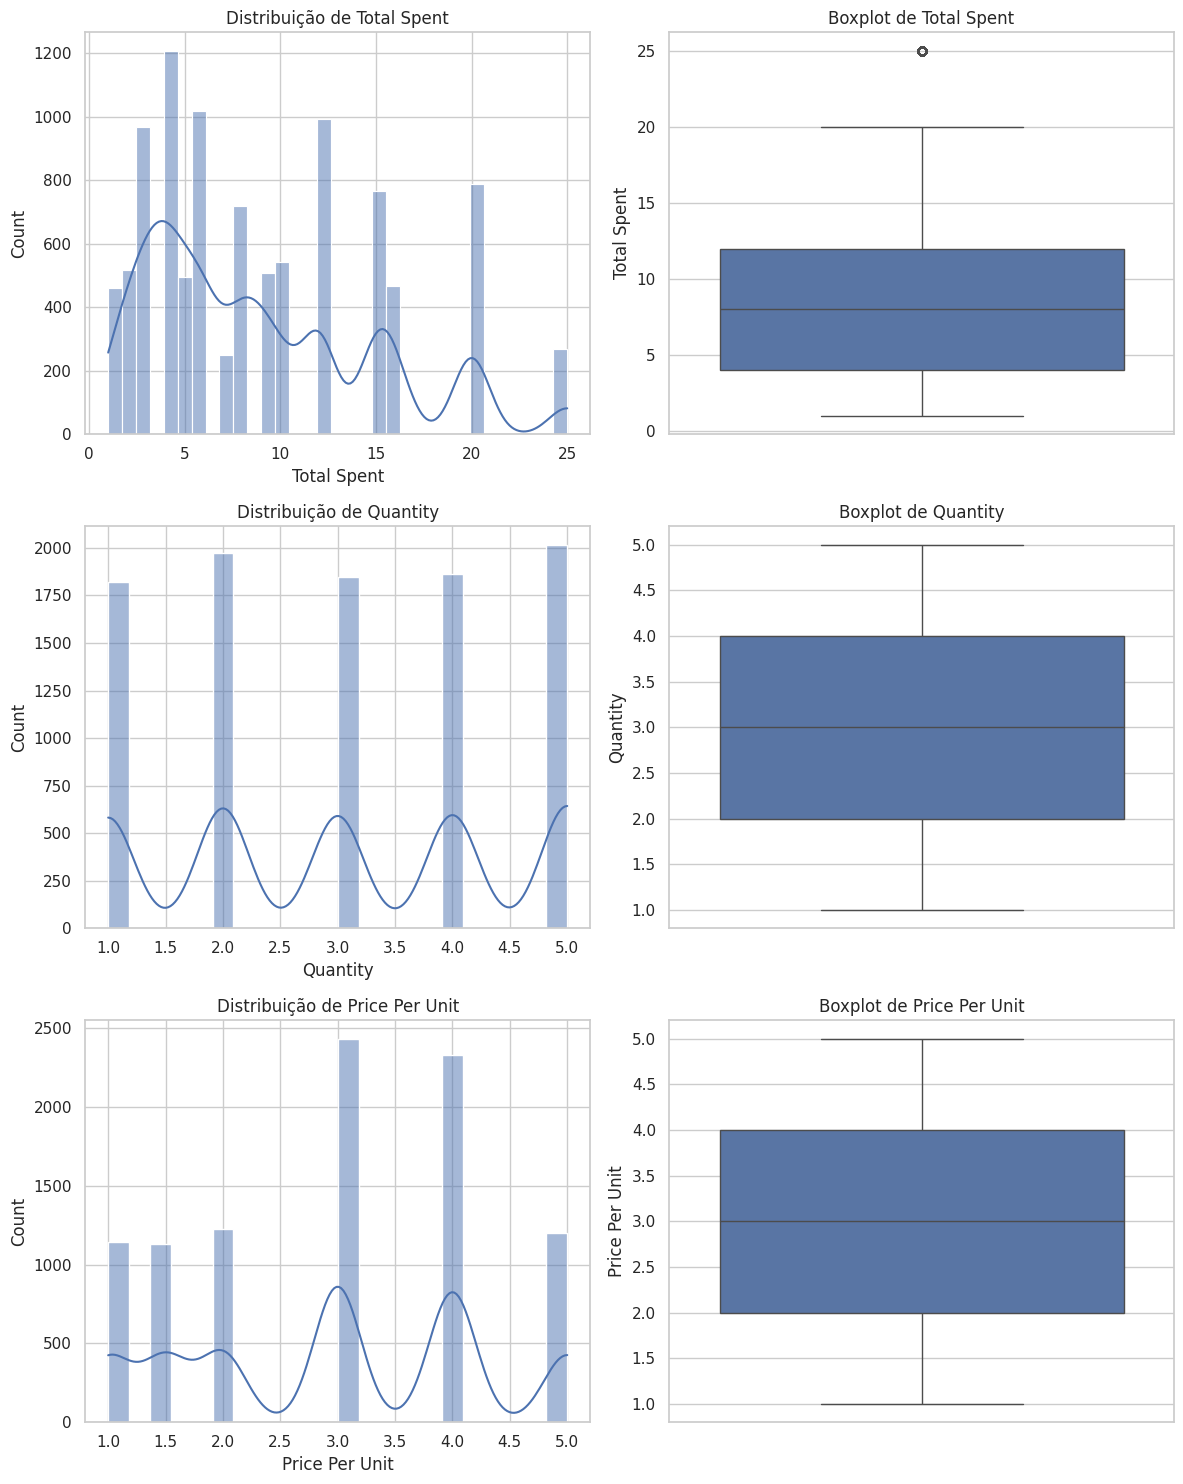

In [ ]:
# prompt: faça Histogramas e boxplots de Total Spent, Quantity, Price Per Unit.

import matplotlib.pyplot as plt
# Configurações para os gráficos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# Histograma e Boxplot para 'Total Spent'
sns.histplot(df['Total Spent'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribuição de Total Spent')
sns.boxplot(y=df['Total Spent'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot de Total Spent')

# Histograma e Boxplot para 'Quantity'
sns.histplot(df['Quantity'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribuição de Quantity')
sns.boxplot(y=df['Quantity'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot de Quantity')

# Histograma e Boxplot para 'Price Per Unit'
sns.histplot(df['Price Per Unit'], ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Distribuição de Price Per Unit')
sns.boxplot(y=df['Price Per Unit'], ax=axes[2, 1])
axes[2, 1].set_title('Boxplot de Price Per Unit')

plt.tight_layout()
plt.show()

In [ ]:
# Cria indicadores de missing
for col in numeric_cols + ['Item', 'Payment Method', 'Location']:
    df[f'{col}_missing'] = df[col].isna().astype(int)

# Imputação
# Handle specific imputation requirements
df['Payment Method'].fillna('Unknown', inplace=True)
df['Location'].fillna('Unknown', inplace=True)
df.dropna(subset=['Item'], inplace=True) # Remove rows where Item is missing
rows_with_date_errors = df[df['Transaction Date'].isna()]

if not rows_with_date_errors.empty:
    print("Rows with errors in 'Transaction Date':")
    display(rows_with_date_errors)
    # Remove rows with errors in 'Transaction Date'
    df.dropna(subset=['Transaction Date'], inplace=True)
    print("\nRows with errors in 'Transaction Date' have been removed.")

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

numeric_full   = numeric_cols + ['AvgSpendingPerItem', 'Quarter']
# Update categorical columns as 'Payment Method' is handled separately
categorical    = ['Location'] # Item was dropped, Payment Method is 'Unknown'

df[numeric_full] = num_imputer.fit_transform(df[numeric_full])
df[categorical]  = cat_imputer.fit_transform(df[categorical])

# Re-add 'Item' and 'Payment Method' to the categorical list for feature selection later
categorical = ['Item', 'Payment Method', 'Location']

In [ ]:
df[categorical]

,Item,Payment Method,Location
0,Coffee,Credit Card,Takeaway
1,Cake,Cash,In-store
2,Cookie,Credit Card,In-store
3,Salad,Unknown,Unknown
4,Coffee,Digital Wallet,In-store
...,...,...,...
9993,Smoothie,Cash,Unknown
9995,Coffee,Unknown,Unknown
9997,Coffee,Digital Wallet,Unknown
9998,Cookie,Digital Wallet,Unknown


In [ ]:
#scaler = StandardScaler()
#df[numeric_full] = scaler.fit_transform(df[numeric_full])

In [ ]:
features = numeric_full + categorical + [col for col in df.columns if col.endswith('_missing')]
X = df[features].copy()

# KPrototypes needs numpy array; categorical cols indices
cat_idx = [X.columns.get_loc(col) for col in categorical]
X_np = X.values

print('Total features:', len(features), '| Categorical:', len(categorical))

Total features: 14 | Categorical: 3


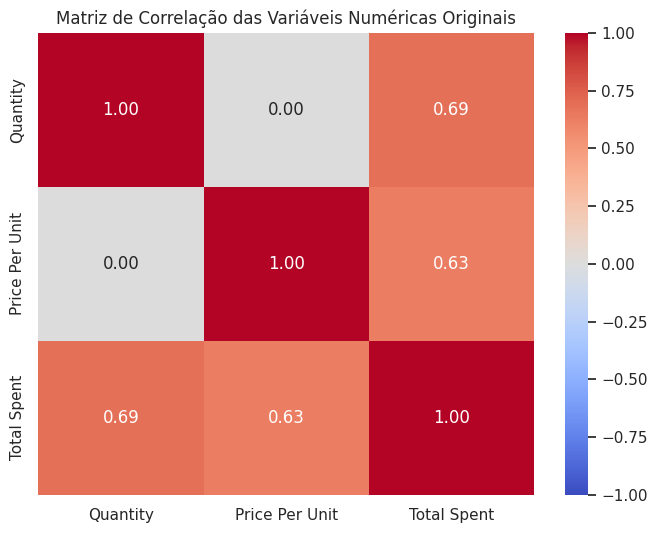

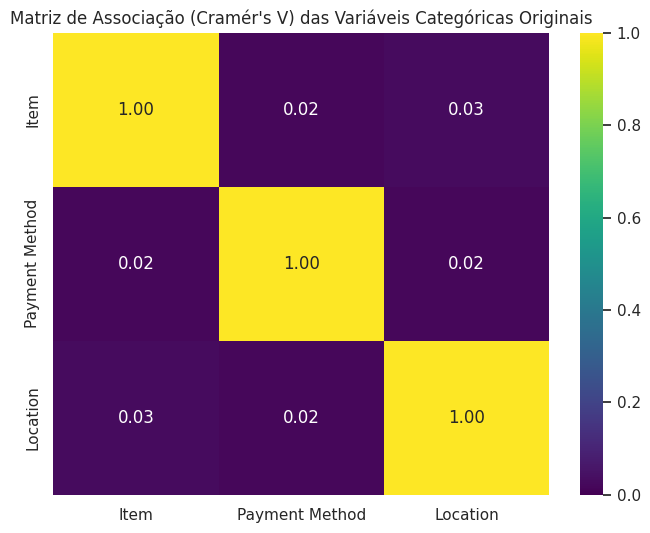

In [ ]:
# prompt: faça uma matriz de correlação entre as variaveis do dataset, depois faça para variaveis categoricas. Não utilize as variaveis que criamos anteriormente, apenas as do dataset em si. Nas escalas de ambas as matrizes, deie a escala padrão (-1,1) (0,1), etc

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Matriz de Correlação para Variáveis Numéricas
# Seleciona apenas as colunas numéricas originais (sem as criadas ou missing indicators)
numeric_original_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
df_numeric = df[numeric_original_cols]

# Calcula a matriz de correlação
corr_matrix_numeric = df_numeric.corr()

# Plota a matriz de correlação numérica
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlação das Variáveis Numéricas Originais')
plt.show()

# Matriz de Associação (Correlação para Variáveis Categóricas)
# Usaremos o coeficiente de Cramér's V para medir a associação entre variáveis categóricas
# Seleciona apenas as colunas categóricas originais
categorical_original_cols = ['Item', 'Payment Method', 'Location']
df_categorical = df[categorical_original_cols]

def cramers_v(x, y):
    """Calcula o coeficiente V de Cramér entre duas séries categóricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

import scipy.stats as stats

n_categorical = len(categorical_original_cols)
cramer_matrix = np.ones((n_categorical, n_categorical))

for i in range(n_categorical):
    for j in range(i + 1, n_categorical):
        v = cramers_v(df_categorical[categorical_original_cols[i]], df_categorical[categorical_original_cols[j]])
        cramer_matrix[i, j] = cramer_matrix[j, i] = v

cramer_df = pd.DataFrame(cramer_matrix, index=categorical_original_cols, columns=categorical_original_cols)

# Plota a matriz de associação categórica
plt.figure(figsize=(8, 6))
sns.heatmap(cramer_df, annot=True, cmap='viridis', fmt=".2f", vmin=0, vmax=1)
plt.title("Matriz de Associação (Cramér's V) das Variáveis Categóricas Originais")
plt.show()


In [ ]:
best_k, best_score = None, -1
for k in range(2, 9):
    kp = KPrototypes(n_clusters=k, init='Huang', random_state=42, n_init=5)
    labels = kp.fit_predict(X_np, categorical=cat_idx)
    # Silhouette only on numeric part for speed/meaning
    try:
        sil = silhouette_score(X[numeric_full], labels, metric='euclidean')
    except Exception:
        sil = np.nan
    print(f'k={k}: silhouette={sil:.3f}')
    if sil > best_score:
        best_k, best_score, best_labels, best_model = k, sil, labels, kp

print(f'\nMelhor k: {best_k} | Silhouette: {best_score:.3f}')
df['Cluster'] = best_labels

k=2: silhouette=0.554
k=3: silhouette=0.444
k=4: silhouette=0.403
k=5: silhouette=0.391
k=6: silhouette=0.373
k=7: silhouette=0.348
k=8: silhouette=0.377

Melhor k: 2 | Silhouette: 0.554


In [ ]:
summary = df.groupby('Cluster').agg(
    n_transactions = ('Transaction ID', 'count'),
    mean_total_spent = ('Total Spent', 'mean'),
    top_item = ('Item', lambda s: s.value_counts().idxmax()),
    dominant_payment = ('Payment Method', lambda s: s.value_counts().idxmax()),
    pct_takeaway = ('Location', lambda s: (s == 'Takeaway').mean())
).sort_values('n_transactions', ascending=False)
display(summary)

,n_transactions,mean_total_spent,top_item,dominant_payment,pct_takeaway
Cluster,,,,,
0,5792,5.362224,Coffee,Unknown,0.307320
1,2821,16.279688,Sandwich,Unknown,0.291741


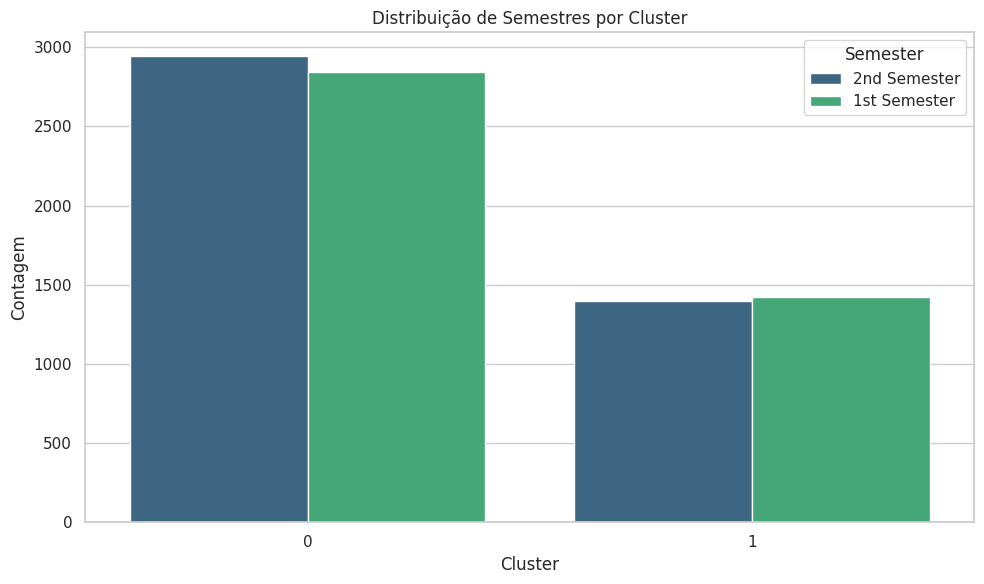

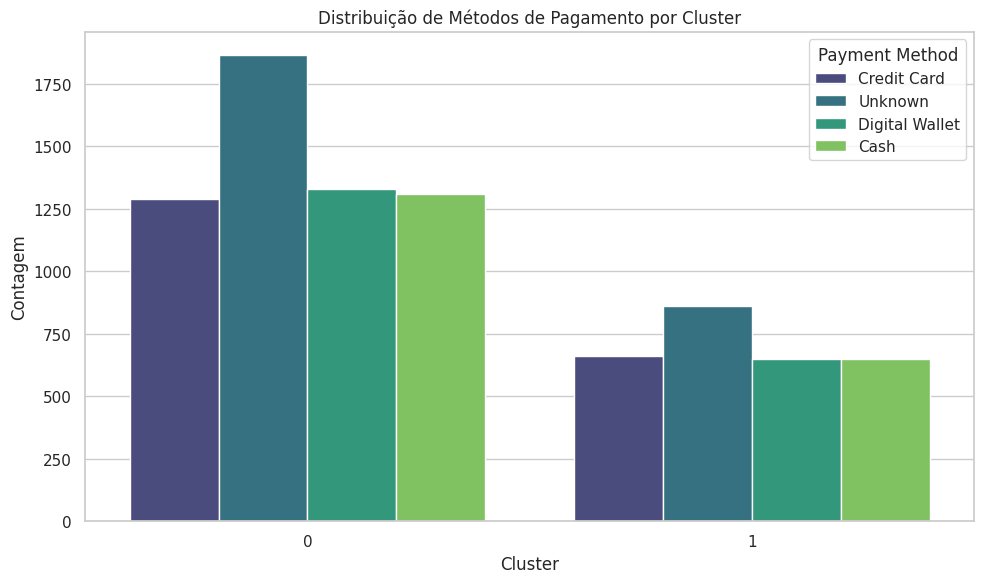

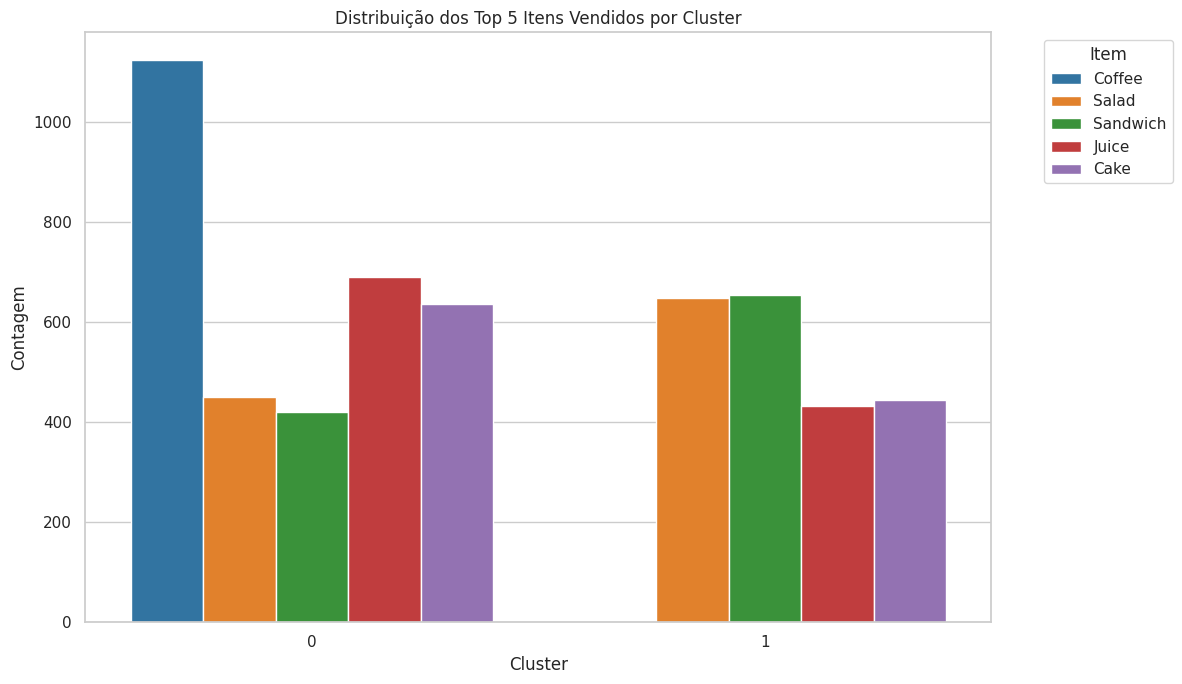

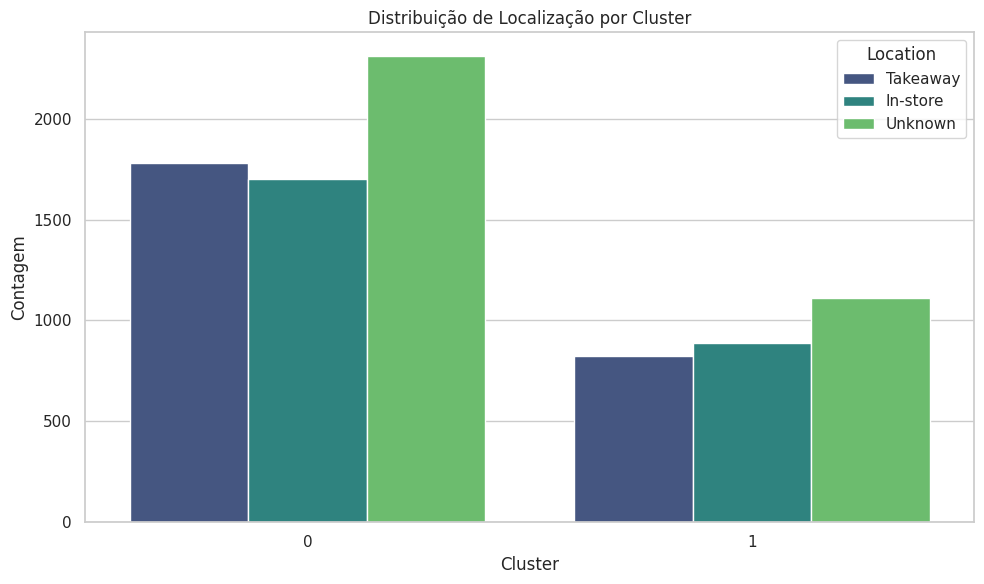

In [ ]:
# prompt: Após fazer os clusters, quero verificar a distribuição dos semestres nos clusters, depois, os metodos de pagamento, e depois os itens vendidos, e na localização tbm. faça todos ps graficos

import matplotlib.pyplot as plt
import numpy as np
# Função para plotar distribuição por cluster
def plot_cluster_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Cluster', hue=column, palette='viridis')
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel('Contagem')
    plt.xticks(rotation=0)
    plt.legend(title=column)
    plt.tight_layout()
    plt.show()

# Verificar a distribuição dos semestres nos clusters
df['Semester'] = np.where(df['Quarter'] <= 2, '1st Semester', '2nd Semester')
plot_cluster_distribution(df, 'Semester', 'Distribuição de Semestres por Cluster')


# Verificar a distribuição dos métodos de pagamento nos clusters
plot_cluster_distribution(df, 'Payment Method', 'Distribuição de Métodos de Pagamento por Cluster')

# Verificar a distribuição dos itens vendidos nos clusters (pegar top N ou os mais frequentes)
# Para evitar muitos itens, vamos pegar os top 5 mais frequentes em todo o dataset e focar neles
top_items = df['Item'].value_counts().nlargest(5).index.tolist()
df_top_items = df[df['Item'].isin(top_items)]

plt.figure(figsize=(12, 7))
sns.countplot(data=df_top_items, x='Cluster', hue='Item', palette='tab10')
plt.title('Distribuição dos Top 5 Itens Vendidos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Verificar a distribuição da localização (Takeaway vs In-Store) nos clusters
plot_cluster_distribution(df, 'Location', 'Distribuição de Localização por Cluster')


Item,Cake,Coffee,Cookie,Juice,Salad,Sandwich,Smoothie,Tea
Cluster,,,,,,,,
0,637,1123,1035,691,451,421,407,1027
1,445,0,0,433,648,654,641,0



Contagem de Itens para o Cluster 0:
Item
Coffee      1123
Cookie      1035
Tea         1027
Juice        691
Cake         637
Salad        451
Sandwich     421
Smoothie     407
Name: count, dtype: int64

Contagem de Itens para o Cluster 1:
Item
Sandwich    654
Salad       648
Smoothie    641
Cake        445
Juice       433
Name: count, dtype: int64


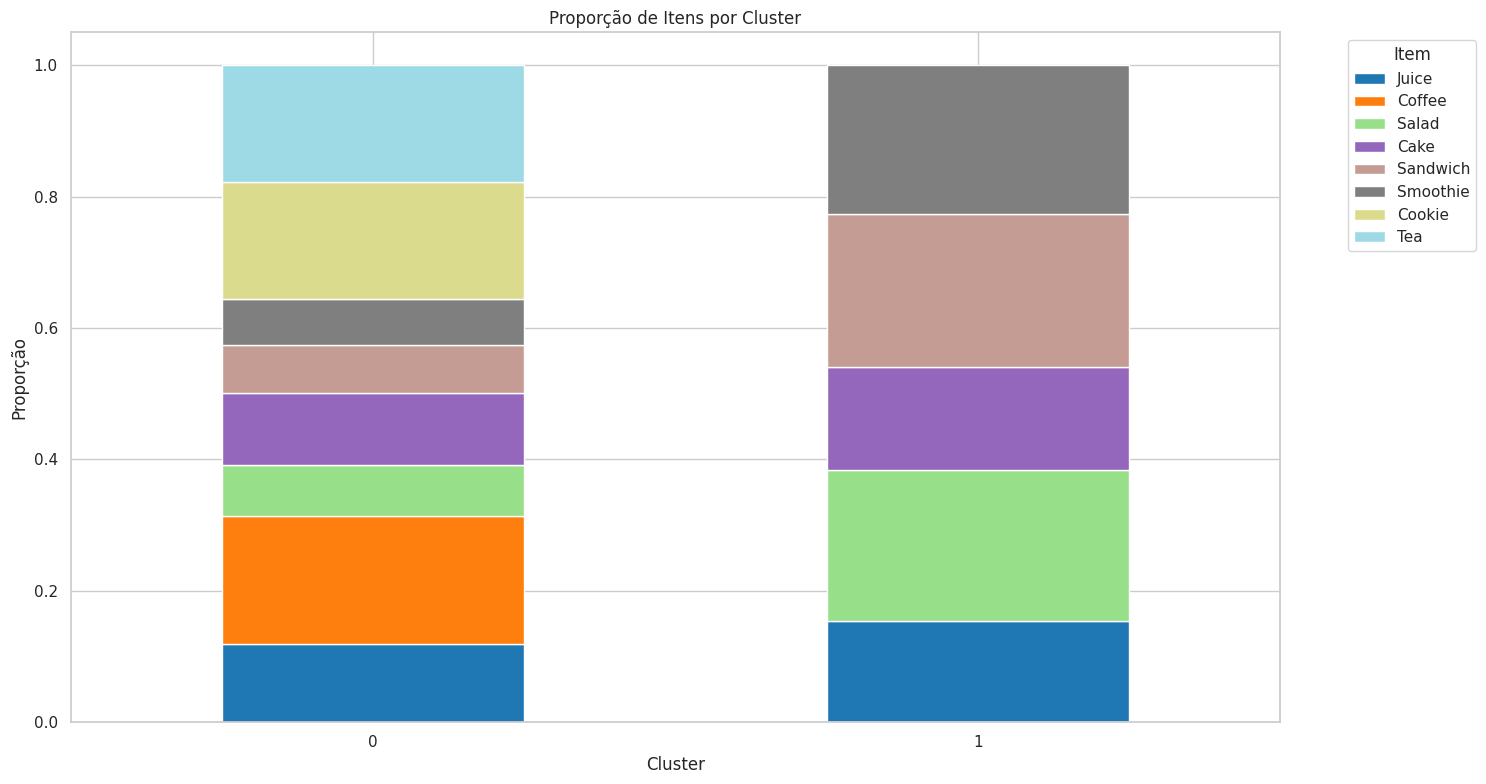

In [ ]:
# prompt: faça uma contagem de itens de comida/bebida por cluster

import matplotlib.pyplot as plt
# Faça uma contagem de itens de comida/bebida por cluster
# Assumindo que 'Item' contém os nomes dos itens de comida/bebida

# Contagem de itens por cluster
item_counts_by_cluster = df.groupby('Cluster')['Item'].value_counts().unstack(fill_value=0)

# Para visualizar melhor, você pode exibir a tabela
display(item_counts_by_cluster)

# Ou, para cada cluster, listar os itens mais frequentes
for cluster in sorted(df['Cluster'].unique()):
    print(f"\nContagem de Itens para o Cluster {cluster}:")
    # Filtra o dataframe pelo cluster atual
    cluster_df = df[df['Cluster'] == cluster]
    # Conta a frequência de cada item neste cluster e imprime
    print(cluster_df['Item'].value_counts().head(10)) # Exibe os 10 itens mais frequentes por cluster

# Visualização: O gráfico de distribuição dos top 5 itens já ajuda a ver isso
# mas podemos criar um gráfico de barras empilhadas para ver a proporção
# de cada item dentro de cada cluster (para todos os itens, se não for muito grande)

# Prepara os dados para um gráfico de barras empilhadas
# Calcula a proporção de cada item dentro de cada cluster
item_cluster_proportion = item_counts_by_cluster.apply(lambda x: x / x.sum(), axis=1)

# Se houver muitos itens, selecione apenas os top N ou filtre
# Para este exemplo, vamos usar os top 10 itens gerais para visualização,
# ou você pode ajustar com base nos insights da tabela item_counts_by_cluster
top_overall_items = df['Item'].value_counts().nlargest(10).index.tolist()
item_cluster_proportion_top = item_cluster_proportion[top_overall_items]

# Plotagem do gráfico de barras empilhadas
item_cluster_proportion_top.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Proporção de Itens por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



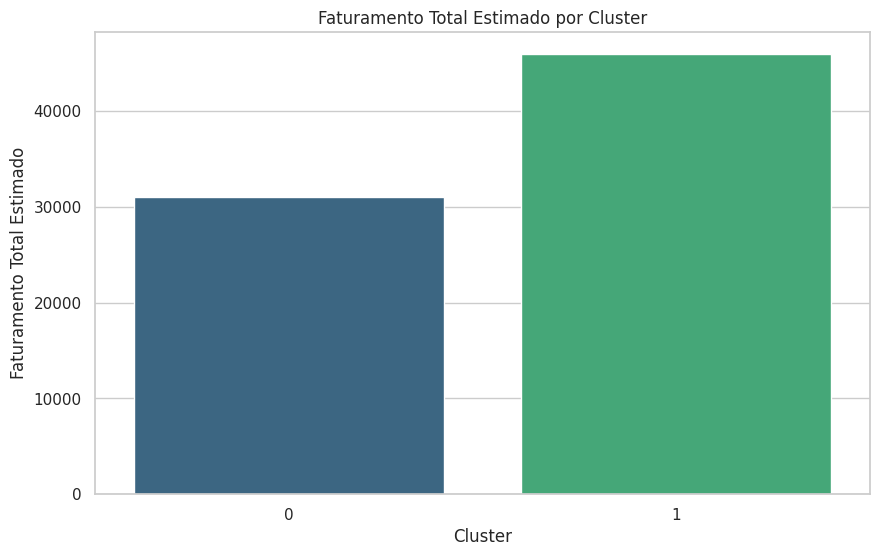

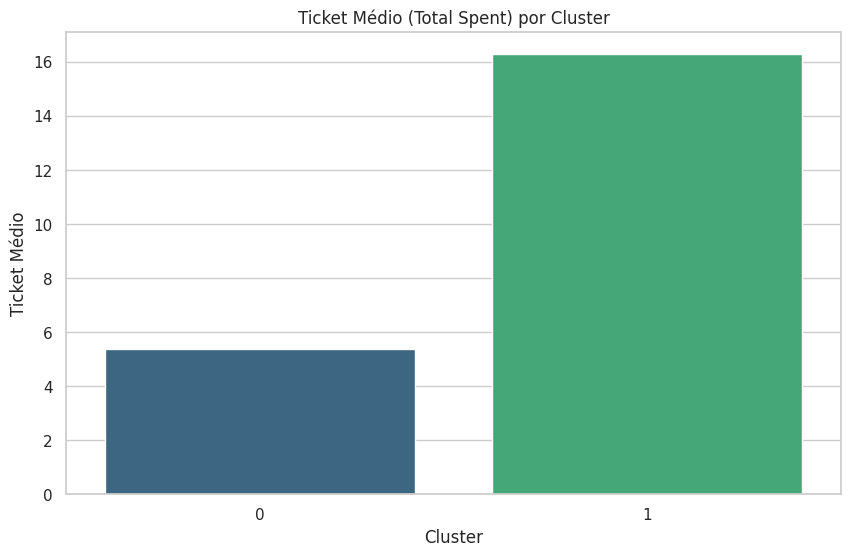

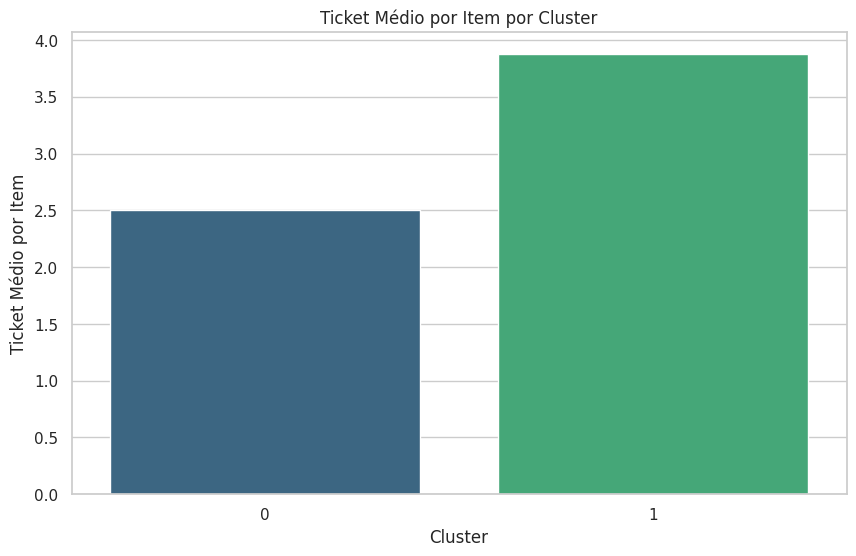

In [ ]:
# prompt: Por fim, poderia gerar um grafico ou algo que indique os faturamentos totais, ou ticket medio nos clusters e afins?

import matplotlib.pyplot as plt
# Análise Visual dos Faturamentos Totais e Ticket Médio por Cluster

# Faturamento Total por Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=summary.index, y=summary['n_transactions'] * summary['mean_total_spent'], palette='viridis')
plt.title('Faturamento Total Estimado por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Faturamento Total Estimado')
plt.show()

# Ticket Médio (Total Spent) por Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=summary.index, y=summary['mean_total_spent'], palette='viridis')
plt.title('Ticket Médio (Total Spent) por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ticket Médio')
plt.show()

# Ticket Médio por Item por Cluster
# Usando a coluna 'AvgSpendingPerItem' calculada anteriormente
avg_spending_summary = df.groupby('Cluster')['AvgSpendingPerItem'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_spending_summary['Cluster'], y=avg_spending_summary['AvgSpendingPerItem'], palette='viridis')
plt.title('Ticket Médio por Item por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ticket Médio por Item')
plt.show()

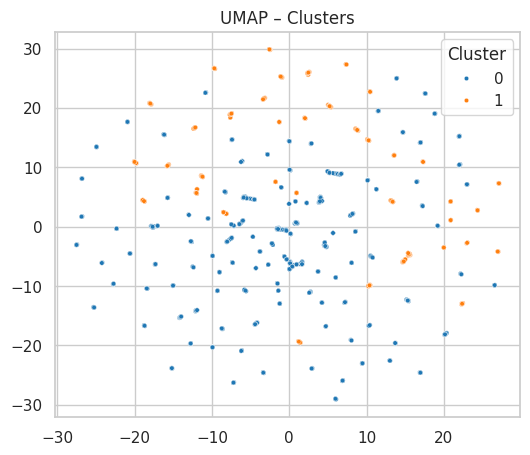

In [ ]:
# 2‑D UMAP plot for visual insight (optional)
try:
    import umap
    reducer = umap.UMAP(random_state=42)
    X_emb = reducer.fit_transform(X[numeric_full])
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_emb[:,0], y=X_emb[:,1], hue=df['Cluster'], palette='tab10', s=10)
    plt.title('UMAP – Clusters')
    plt.show()
except ModuleNotFoundError:
    print('UMAP não instalado. Pulei a visualização.')

In [ ]:
OUTPUT_CSV = 'dirty_cafe_sales_cleaned_clusters.csv'
df.to_csv(OUTPUT_CSV, index=False)
print(f'Dataset limpo + clusters salvo em {OUTPUT_CSV}')

Dataset limpo + clusters salvo em dirty_cafe_sales_cleaned_clusters.csv


In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
output_filename = 'df_download.csv'
df.to_csv(output_filename, index=False)

# Provide a download link
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>